In [175]:
import os
import numpy as np
import mediapipe as mp
import torch
import cv2
from mediapipe.python.solutions.pose import POSE_CONNECTIONS

In [176]:
# # Load the dataset
# import pickle
# # "pkl_folder/train_ur_fall_50_frames_4_features.pkl", "pkl_folder/val_ur_fall_50_frames_4_features.pkl"
# data_paths = ["pkl_folder/coffee_room_dataset.pkl", "pkl_folder/lecture_room_dataset.pkl", "pkl_folder/office_dataset.pkl", "pkl_folder/home_dataset.pkl"]
# loaded_dataset = []
# # output_file = "pkl_folder/lecture_room_dataset.pkl"
# for file in data_paths:
#     with open(file, 'rb') as f:
#         loaded_dataset.extend(pickle.load(f))
    
# # with open(output_file, 'rb') as f:
# #     loaded_dataset = pickle.load(f)
# print(f"Loaded dataset size: {len(loaded_dataset)}")
# type(loaded_dataset[0])
# print(f"Type of first element in tuple: {type(loaded_dataset[0][0])}")
# print(f"Type of second element in tuple: {type(loaded_dataset[0][1])}")

In [177]:
import pickle 

input_file = "train_falls_le2_v2.pkl"
with open(input_file, 'rb') as f:
    loaded_dataset = pickle.load(f)

test_file = "test_falls_le2_v2.pkl"
with open(test_file, 'rb') as f:
    loaded_test_dataset = pickle.load(f)

In [178]:
# import pickle

# with open('pkl_folder/train_ur_fall_50_frames_4_features.pkl', 'rb') as f:
#     train_data_new_set = pickle.load(f)
# with open('pkl_folder/val_ur_fall_50_frames_4_features.pkl', 'rb') as f:
#     test_data_new_set = pickle.load(f)

# train_data = [(torch.tensor(data[0].numpy()).permute(2, 0, 1), data[1]) for data in train_data_new_set]
# test_data = [(torch.tensor(data[0].numpy()).permute(2, 0, 1), data[1]) for data in test_data_new_set]

In [179]:
import numpy as np

class Graph:
    def __init__(self, strategy='uniform', max_hop=1, dilation=1):
        self.strategy = strategy
        self.max_hop = max_hop
        self.dilation = dilation

        self.get_edge()
        self.hop_dis = self._get_hop_distance(self.num_node, self.edge, max_hop)
        self._build_adjacency(strategy)

    def get_edge(self):
        self.num_node = 33
        self.center = 24  # Based on pose structure

        self_link = [(i, i) for i in range(self.num_node)]
        neighbor_link = [
            (0, 1), (1, 2), (2, 3), (3, 7),
            (0, 4), (4, 5), (5, 6), (6, 8),
            (9, 10), (11, 12), (11, 13), (13, 15),
            (15, 17), (15, 19), (15, 21), (17, 19),
            (12, 14), (14, 16), (16, 18), (16, 20),
            (16, 22), (18, 20), (11, 23), (12, 24),
            (23, 24), (23, 25), (24, 26), (25, 27),
            (26, 28), (27, 29), (28, 30), (29, 31),
            (30, 32), (27, 31), (28, 32)
        ]

        self.edge = self_link + neighbor_link

    def _get_hop_distance(self, num_node, edge, max_hop=1):
        A = np.zeros((num_node, num_node))
        for i, j in edge:
            A[j, i] = 1
            A[i, j] = 1

        hop_dis = np.full((num_node, num_node), np.inf)
        transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
        arrive_mat = (np.stack(transfer_mat) > 0)

        for d in range(max_hop, -1, -1):
            hop_dis[arrive_mat[d]] = d

        return hop_dis

    def _normalize_digraph(self, A):
        Dl = np.sum(A, axis=0)
        Dn = np.zeros_like(A)
        for i in range(A.shape[0]):
            if Dl[i] > 0:
                Dn[i, i] = Dl[i]**(-1)
        return A @ Dn

    def _normalize_undigraph(self, A):
        Dl = np.sum(A, axis=0)
        Dn = np.zeros_like(A)
        for i in range(A.shape[0]):
            if Dl[i] > 0:
                Dn[i, i] = Dl[i]**(-0.5)
        return Dn @ A @ Dn

    def _get_adjacency_uniform(self, normalize_adjacency):
        A = np.zeros((1, self.num_node, self.num_node))
        A[0] = normalize_adjacency
        return A

    def _get_adjacency_distance(self, normalize_adjacency, valid_hop):
        A = np.zeros((len(valid_hop), self.num_node, self.num_node))
        for i, hop in enumerate(valid_hop):
            A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
        return A

    def _get_adjacency_spatial(self, normalize_adjacency, valid_hop):
        A = []
        for hop in valid_hop:
            a_root = np.zeros((self.num_node, self.num_node))
            a_close = np.zeros((self.num_node, self.num_node))
            a_further = np.zeros((self.num_node, self.num_node))

            for i in range(self.num_node):
                for j in range(self.num_node):
                    if self.hop_dis[j, i] == hop:
                        if self.hop_dis[j, self.center] == self.hop_dis[i, self.center]:
                            a_root[j, i] = normalize_adjacency[j, i]
                        elif self.hop_dis[j, self.center] > self.hop_dis[i, self.center]:
                            a_close[j, i] = normalize_adjacency[j, i]
                        else:
                            a_further[j, i] = normalize_adjacency[j, i]

            if hop == 0:
                A.append(a_root)
            else:
                A.append(a_root + a_close)
                A.append(a_further)

        return np.stack(A)

    def _get_adjacency_spectral(self):
        L = self.get_normalized_laplacian()
        L = np.abs(L)
        L = self._normalize_digraph(L)
        A = np.zeros((1, self.num_node, self.num_node))
        A[0] = L
        return A

    def _build_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = self._normalize_digraph(adjacency)

        if strategy == 'uniform':
            self.A = self._get_adjacency_uniform(normalize_adjacency)
        elif strategy == 'distance':
            self.A = self._get_adjacency_distance(normalize_adjacency, valid_hop)
        elif strategy == 'spatial':
            self.A = self._get_adjacency_spatial(normalize_adjacency, valid_hop)
        elif strategy == 'spectral':
            self.A = self._get_adjacency_spectral()
        elif strategy == 'hybrid':
            A_spectral = self._get_adjacency_spectral()
            A_spatial = self._get_adjacency_spatial(normalize_adjacency, valid_hop)
            self.A = np.concatenate((A_spectral, A_spatial), axis=0)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

    def get_normalized_laplacian(self):
        D = np.diag(self.original_A.sum(axis=1))
        D_inv_sqrt = np.linalg.inv(np.sqrt(D))
        L = np.eye(self.num_node) - D_inv_sqrt @ self.original_A @ D_inv_sqrt
        return L

    @property
    def original_A(self):
        A = np.zeros((self.num_node, self.num_node))
        for i, j in self.edge:
            A[i, j] = 1
            A[j, i] = 1
        return A


In [180]:
import torch.nn as nn

class ConvTemporalGraphical(nn.Module):
    r"""The basic module for applying a graph convolution.

    Args:
        in_channels (int): Number of channels in the input sequence data
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int): Size of the graph convolving kernel
        t_kernel_size (int): Size of the temporal convolving kernel
        t_stride (int, optional): Stride of the temporal convolution. Default: 1
        t_padding (int, optional): Temporal zero-padding added to both sides of
            the input. Default: 0
        t_dilation (int, optional): Spacing between temporal kernel elements.
            Default: 1
        bias (bool, optional): If ``True``, adds a learnable bias to the output.
            Default: ``True``

    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Output graph sequence in :math:`(N, out_channels, T_{out}, V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)` format

        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes. 
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 t_kernel_size=1,
                 t_stride=1,
                 t_padding=0,
                 t_dilation=1,
                 bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(in_channels,
                              out_channels * kernel_size,
                              kernel_size=(t_kernel_size, 1),
                              padding=(t_padding, 0),
                              stride=(t_stride, 1),
                              dilation=(t_dilation, 1),
                              bias=bias)

    def forward(self, x, A):
        assert A.size(0) == self.kernel_size

        x = self.conv(x)

        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc // self.kernel_size, t, v)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))

        return x.contiguous(), A

In [181]:
def zero(x):
    return 0

def iden(x):
    return x

class st_gcn_block(nn.Module):
    r"""Applies a spatial temporal graph convolution over an input graph sequence.

    Args:
        in_channels (int): Number of channels in the input sequence data
        out_channels (int): Number of channels produced by the convolution
        kernel_size (tuple): Size of the temporal convolving kernel and graph convolving kernel
        stride (int, optional): Stride of the temporal convolution. Default: 1
        dropout (int, optional): Dropout rate of the final output. Default: 0
        residual (bool, optional): If ``True``, applies a residual mechanism. Default: ``True``

    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Output graph sequence in :math:`(N, out_channels, T_{out}, V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)` format

        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.

    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dropout=0,
                 residual=True):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        self.gcn = ConvTemporalGraphical(in_channels, out_channels,
                                         kernel_size[1])

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                (kernel_size[0], 1),
                (stride, 1),
                padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        if not residual:
            self.residual = zero

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = iden

        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=1,
                          stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A):

        res = self.residual(x)
        x, A = self.gcn(x, A)
        x = self.tcn(x) + res

        return self.relu(x), A

In [182]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ST_GCN_18(nn.Module):
    def __init__(self,
                 in_channels,
                 num_class,
                 graph_cfg,
                 edge_importance_weighting=True,
                 data_bn=True,
                 **kwargs):
        super().__init__()

        # Load graph and adjacency matrix
        self.graph = Graph(**graph_cfg)
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)

        # Optional: only needed in Hybrid variant
        if hasattr(self.graph, 'get_laplacian'):
            L = torch.tensor(self.graph.get_laplacian(), dtype=torch.float32, requires_grad=False)
            self.register_buffer('L', L)

        # Compute kernel sizes
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)

        # Data normalization
        self.data_bn = nn.BatchNorm1d(in_channels * A.size(1)) if data_bn else nn.Identity()

        # ST-GCN layers
        kwargs0 = {k: v for k, v in kwargs.items() if k != 'dropout'}
        self.st_gcn_networks = nn.ModuleList([
            st_gcn_block(in_channels, 64, kernel_size, 1, residual=False, **kwargs0),
            st_gcn_block(64, 64, kernel_size, 1, **kwargs),
            st_gcn_block(64, 64, kernel_size, 1, **kwargs),
            st_gcn_block(64, 64, kernel_size, 1, **kwargs),
            st_gcn_block(64, 128, kernel_size, 2, **kwargs),
            st_gcn_block(128, 128, kernel_size, 1, **kwargs),
            st_gcn_block(128, 128, kernel_size, 1, **kwargs),
            st_gcn_block(128, 256, kernel_size, 2, **kwargs),
            st_gcn_block(256, 256, kernel_size, 1, **kwargs),
            st_gcn_block(256, 256, kernel_size, 1, **kwargs),
        ])
        # self.st_gcn_networks = nn.ModuleList([
        #     st_gcn_block(in_channels, 32, kernel_size, 1, residual=False, **kwargs0),
        #     st_gcn_block(32, 32, kernel_size, 1, **kwargs),
        #     st_gcn_block(32, 64, kernel_size, 2, **kwargs),
        # ])

        # Edge importance weights (learnable)
        self.edge_importance = nn.ParameterList([
            nn.Parameter(torch.ones_like(self.A)) for _ in self.st_gcn_networks
        ]) if edge_importance_weighting else [1] * len(self.st_gcn_networks)

        # Output classifier
        self.fcn = nn.Conv2d(256, num_class, kernel_size=1)
        # self.fcn = nn.Conv2d(64, num_class, kernel_size=1)

    def forward(self, x):
        # Input: (N, C, T, V)
        N, C, T, V = x.size()

        # Normalize
        x = x.permute(0, 3, 1, 2).contiguous()     # (N, V, C, T)
        x = x.view(N, V * C, T)                    # (N, VC, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T).permute(0, 2, 3, 1) # (N, C, T, V)

        # ST-GCN blocks
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x, _ = gcn(x, self.A * importance)

        # Global average pooling
        x = F.avg_pool2d(x, x.size()[2:])          
        x = x.view(N, -1, 1, 1)
        x = self.fcn(x)                            
        return x.view(x.size(0), -1)               

In [183]:
class SpectralConv(nn.Module):
    def __init__(self, in_channels, out_channels, K):
        super().__init__()
        self.K = K
        # Weight shape should be (out_channels, in_channels, K)
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, K))
        nn.init.xavier_uniform_(self.weight)
        
    def forward(self, x, L):
        N, C, T, V = x.shape
        x = x.permute(0, 2, 3, 1).contiguous()  # (N, T, V, C)
        
        out = torch.zeros(N, T, V, self.weight.shape[0], device=x.device)
        
        Tx_0 = x  # T_0(x)
        out += torch.einsum('oc,ntvc->ntvo', self.weight[:, :, 0], Tx_0)
        
        if self.K > 1:
            Tx_1 = torch.matmul(L, Tx_0)  # T_1(x)
            out += torch.einsum('oc,ntvc->ntvo', self.weight[:, :, 1], Tx_1)

            for k in range(2, self.K):
                Tx_2 = 2 * torch.matmul(L, Tx_1) - Tx_0  # Chebyshev recurrence
                out += torch.einsum('oc,ntvc->ntvo', self.weight[:, :, k], Tx_2)
                Tx_0, Tx_1 = Tx_1, Tx_2

        out = out.permute(0, 3, 1, 2).contiguous()  # (N, C_out, T, V)
        return out

In [184]:
class HybridBlock(nn.Module):
    def __init__(self, in_channels, out_channels, spatial_kernel_size, K_spectral, stride=1, dropout=0.0, residual=True):
        super().__init__()
        
        self.spatial_conv = ConvTemporalGraphical(in_channels, out_channels, spatial_kernel_size)
        self.spectral_conv = SpectralConv(in_channels, out_channels, K_spectral)

        # Temporal convolution
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(9, 1), stride=(stride, 1), padding=(4, 0)),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True)
        )

        # Residual connection
        if not residual:
            self.residual = lambda x: 0
        elif in_channels == out_channels and stride == 1:
            self.residual = lambda x: x
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride, 1)),
                nn.BatchNorm2d(out_channels)
            )

        # Fusion weights (learnable)
        self.alpha = nn.Parameter(torch.tensor(0.5))  # balance between spatial and spectral
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A, L):
        res = self.residual(x)

        x_spatial, _ = self.spatial_conv(x, A)
        x_spectral = self.spectral_conv(x, L)

        x_fused = self.alpha * x_spatial + (1 - self.alpha) * x_spectral
        x = self.tcn(x_fused) + res

        return self.relu(x), A


In [185]:
ones = 1
only_falls_dataset = []
for data, label in loaded_dataset:
    if label == 1:
        only_falls_dataset.append((data, label))

In [186]:
# Create DataLoader
from torch.utils.data import DataLoader
batch_size = 16
dataloader = DataLoader(loaded_dataset, batch_size=batch_size, shuffle=True)

# Verify the batch shape
for batch_data, batch_labels in dataloader:
    print(f"Batch data shape: {batch_data.shape}")  # Should be [batch_size, 4, 500, 33], e.g., [2, 4, 500, 33]
    print(f"Batch labels shape: {batch_labels.shape}")  # Should be [batch_size], e.g., [2]
    break

Batch data shape: torch.Size([16, 4, 50, 33])
Batch labels shape: torch.Size([16])


In [187]:
class ST_GCN_Hybrid(ST_GCN_18):
    def __init__(self,
                 in_channels,
                 num_class,
                 graph_cfg,
                 edge_importance_weighting=True,
                 data_bn=True,
                 K_spectral=3,
                 **kwargs):
        super().__init__(
            in_channels=in_channels,
            num_class=num_class,
            graph_cfg=graph_cfg,
            edge_importance_weighting=edge_importance_weighting,
            data_bn=data_bn,
            **kwargs
        )
        
        self.graph = Graph(**graph_cfg)
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)

        L = torch.tensor(self.graph.get_normalized_laplacian(), dtype=torch.float32, requires_grad=False)
        self.register_buffer('L', L)

        # Replace first few standard ST-GCN blocks with HybridBlocks
        for i in [0, 1, 2]:  # You can modify the number of hybrid layers here
            self.st_gcn_networks[i] = HybridBlock(
                in_channels=in_channels if i == 0 else 32,
                out_channels=32 if i < 2 else 64,
                spatial_kernel_size=self.A.size(0),
                K_spectral=K_spectral,
                stride=1,
                dropout=kwargs.get('dropout', 0.5),
                residual=False if i == 0 else True
            )

    def forward(self, x):
        # Input: (N, C, T, V)
        N, C, T, V = x.size()

        # Data normalization
        x = x.permute(0, 3, 1, 2).contiguous()     # (N, V, C, T)
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()  # (N, C, T, V)

        # Forward through ST-GCN & Hybrid blocks
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            if isinstance(gcn, HybridBlock):
                x, _ = gcn(x, self.A * importance, self.L)
            else:
                x, _ = gcn(x, self.A * importance)

        # Global pooling and prediction
        x = F.avg_pool2d(x, x.size()[2:])  # (N, 256, 1, 1)
        x = x.view(N, -1, 1, 1)
        x = self.fcn(x)
        return x.view(x.size(0), -1)


In [188]:
import torch
from torch.utils.data import DataLoader, random_split

# 1. Split dataset
dataset_size = len(loaded_dataset)
val_size     = int(0.2 * dataset_size)       # 20% for validation
train_size   = dataset_size - val_size      # remaining 80%

train_dataset, val_dataset = random_split(
    loaded_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# train_dataset = loaded_dataset
# 2. DataLoaders
batch_size = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)



--- Epoch 1/30 ---
Train Loss: 0.4580, Accuracy: 75.86%
Val   Loss: 1.5718, Accuracy: 60.71%

--- Epoch 2/30 ---
Train Loss: 0.4201, Accuracy: 77.59%
Val   Loss: 1.2171, Accuracy: 60.71%

--- Epoch 3/30 ---
Train Loss: 0.3922, Accuracy: 81.90%
Val   Loss: 1.3416, Accuracy: 75.00%

--- Epoch 4/30 ---
Train Loss: 0.3264, Accuracy: 83.62%
Val   Loss: 0.2087, Accuracy: 89.29%

--- Epoch 5/30 ---
Train Loss: 0.3245, Accuracy: 84.48%
Val   Loss: 1.0285, Accuracy: 85.71%


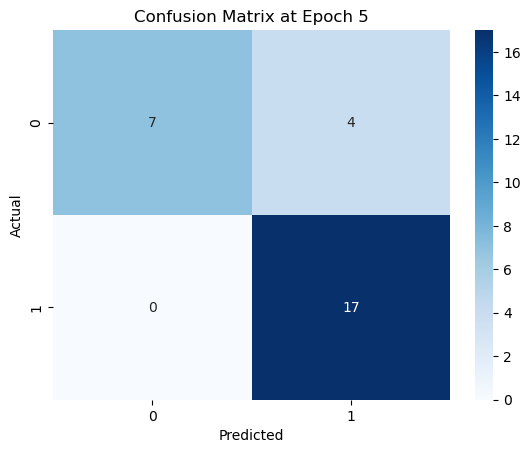

Class counts (Validation): {tensor(0): tensor(11), tensor(1): tensor(17)}

--- Epoch 6/30 ---
Train Loss: 0.3201, Accuracy: 87.07%
Val   Loss: 0.1669, Accuracy: 96.43%

--- Epoch 7/30 ---
Train Loss: 0.2157, Accuracy: 88.79%
Val   Loss: 1.4236, Accuracy: 85.71%

--- Epoch 8/30 ---
Train Loss: 0.2682, Accuracy: 87.07%
Val   Loss: 0.1454, Accuracy: 96.43%

--- Epoch 9/30 ---
Train Loss: 0.2102, Accuracy: 91.38%
Val   Loss: 0.3203, Accuracy: 92.86%

--- Epoch 10/30 ---
Train Loss: 0.2328, Accuracy: 92.24%
Val   Loss: 0.1486, Accuracy: 96.43%


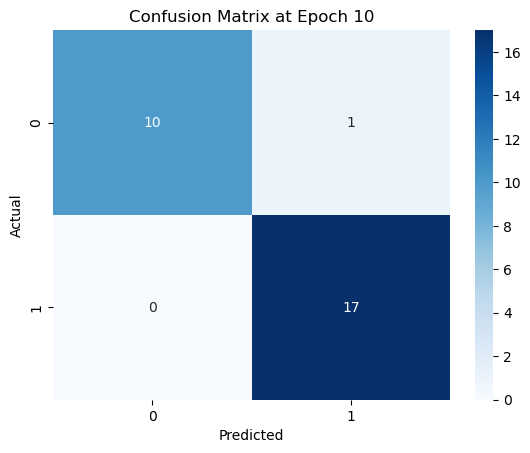

Class counts (Validation): {tensor(0): tensor(11), tensor(1): tensor(17)}

--- Epoch 11/30 ---
Train Loss: 0.3812, Accuracy: 84.48%
Val   Loss: 0.1705, Accuracy: 92.86%

--- Epoch 12/30 ---
Train Loss: 0.2392, Accuracy: 83.62%
Val   Loss: 0.1933, Accuracy: 85.71%

--- Epoch 13/30 ---
Train Loss: 0.1173, Accuracy: 92.24%
Val   Loss: 0.1329, Accuracy: 96.43%

--- Epoch 14/30 ---
Train Loss: 0.1382, Accuracy: 92.24%
Val   Loss: 0.0693, Accuracy: 96.43%

--- Epoch 15/30 ---
Train Loss: 0.3325, Accuracy: 88.79%
Val   Loss: 0.0888, Accuracy: 96.43%


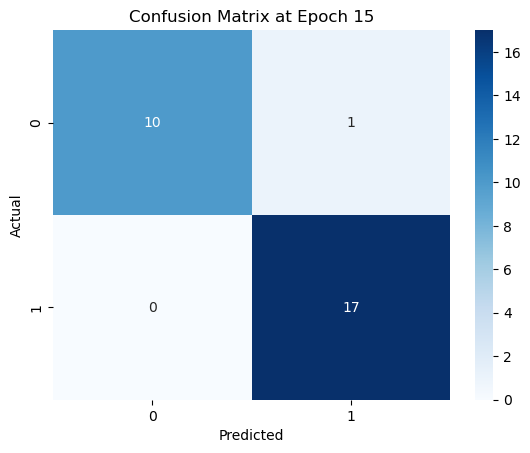

Class counts (Validation): {tensor(0): tensor(11), tensor(1): tensor(17)}

--- Epoch 16/30 ---
Train Loss: 0.2726, Accuracy: 90.52%
Val   Loss: 0.0334, Accuracy: 100.00%

--- Epoch 17/30 ---
Train Loss: 0.2062, Accuracy: 92.24%
Val   Loss: 0.1065, Accuracy: 92.86%

--- Epoch 18/30 ---
Train Loss: 0.1999, Accuracy: 91.38%
Val   Loss: 0.0881, Accuracy: 96.43%

--- Epoch 19/30 ---
Train Loss: 0.1393, Accuracy: 92.24%
Val   Loss: 0.0337, Accuracy: 100.00%

--- Epoch 20/30 ---
Train Loss: 0.0523, Accuracy: 97.41%
Val   Loss: 0.1461, Accuracy: 92.86%


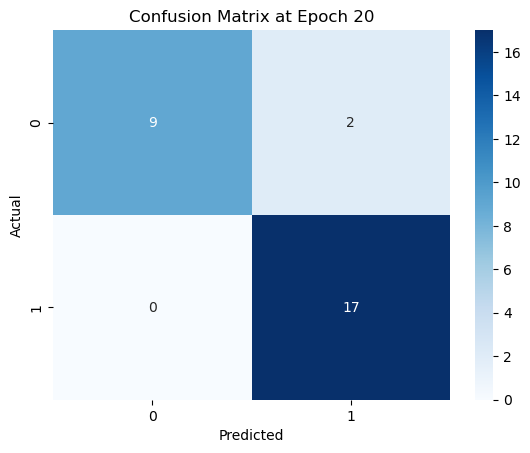

Class counts (Validation): {tensor(0): tensor(11), tensor(1): tensor(17)}

--- Epoch 21/30 ---
Train Loss: 0.2010, Accuracy: 90.52%
Val   Loss: 0.0379, Accuracy: 100.00%

--- Epoch 22/30 ---
Train Loss: 0.1756, Accuracy: 91.38%
Val   Loss: 0.1569, Accuracy: 92.86%

--- Epoch 23/30 ---
Train Loss: 0.1474, Accuracy: 93.97%
Val   Loss: 0.0472, Accuracy: 96.43%

--- Epoch 24/30 ---
Train Loss: 0.1554, Accuracy: 94.83%
Val   Loss: 0.0578, Accuracy: 100.00%

--- Epoch 25/30 ---
Train Loss: 0.1257, Accuracy: 95.69%
Val   Loss: 0.0278, Accuracy: 100.00%


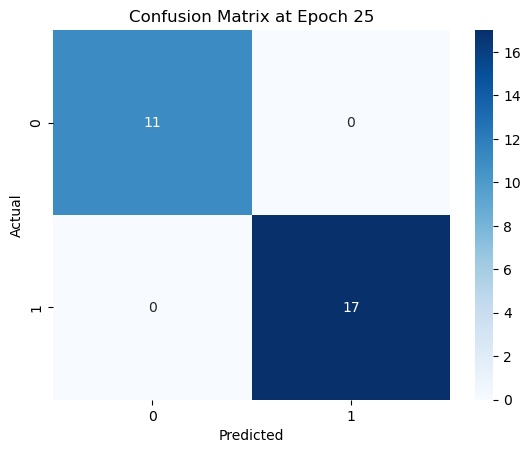

Class counts (Validation): {tensor(0): tensor(11), tensor(1): tensor(17)}

--- Epoch 26/30 ---
Train Loss: 0.1812, Accuracy: 92.24%
Val   Loss: 0.0514, Accuracy: 96.43%

--- Epoch 27/30 ---
Train Loss: 0.1364, Accuracy: 93.10%
Val   Loss: 0.0506, Accuracy: 100.00%

--- Epoch 28/30 ---
Train Loss: 0.1551, Accuracy: 93.97%
Val   Loss: 0.1658, Accuracy: 92.86%

--- Epoch 29/30 ---
Train Loss: 0.2870, Accuracy: 91.38%
Val   Loss: 0.1667, Accuracy: 96.43%

--- Epoch 30/30 ---
Train Loss: 0.0553, Accuracy: 99.14%
Val   Loss: 0.0365, Accuracy: 100.00%


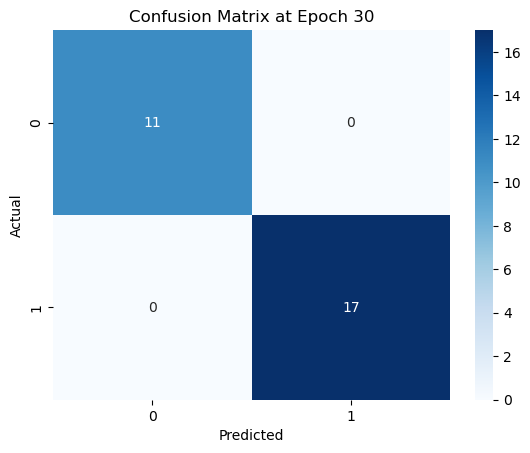

Class counts (Validation): {tensor(0): tensor(11), tensor(1): tensor(17)}


In [189]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

graph_cfg = {'strategy': 'hybrid'}
model = ST_GCN_Hybrid(in_channels=4, num_class=2, graph_cfg=graph_cfg, dropout=0.5).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 30

# --- Sanity check input shape and label distribution ---
# x_sample, y_sample = next(iter(train_loader))
# print("Sample input shape:", x_sample.shape)  # Should be (N, C, T, V)
# print("Sample labels:", y_sample[:5])
# model.train()
for epoch in range(1, num_epochs + 1):
    print(f"\n--- Epoch {epoch}/{num_epochs} ---")

    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        if x_batch.shape[1] != 4:
            x_batch = x_batch.permute(0, 3, 1, 2).contiguous()

        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # running_loss += loss.item() * y_batch.size(0)
        running_loss += loss.item()
        _, predicted = torch.max(preds, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    scheduler.step()

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            if x_val.shape[1] != 4:
                x_val = x_val.permute(0, 3, 1, 2).contiguous()

            val_preds = model(x_val)
            loss = criterion(val_preds, y_val)

            val_loss += loss.item() * y_val.size(0)
            _, val_predicted = val_preds.max(1)
            val_correct += (val_predicted == y_val).sum().item()
            val_total += y_val.size(0)

            all_preds.extend(val_predicted.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    val_loss = val_loss / val_total
    val_acc = 100 * val_correct / val_total

    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # --- Confusion Matrix every few epochs ---
    if epoch % 5 == 0 or epoch == num_epochs:
        cm = confusion_matrix(all_labels, all_preds)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix at Epoch {epoch}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        print("Class counts (Validation):", dict(zip(*torch.unique(torch.tensor(all_labels), return_counts=True))))



In [191]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming `test_dataset` is already loaded and preprocessed
batch_size = 16
test_loader = DataLoader(loaded_test_dataset, batch_size=batch_size, shuffle=True)

# Set the model to evaluation mode
model.eval()

# Initialize variables to store predictions and labels
all_preds = []
all_labels = []

# Perform inference
with torch.no_grad():  # Disable gradient computation for testing
    for batch_data, batch_labels in test_loader:
        # Move data to the same device as the model
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        _, preds = torch.max(outputs, 1)  # Get the predicted class

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Test Accuracy: 0.8649

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.91      0.87      0.89        23

    accuracy                           0.86        37
   macro avg       0.85      0.86      0.86        37
weighted avg       0.87      0.86      0.87        37


Confusion Matrix:
[[12  2]
 [ 3 20]]
